In [1]:
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Load the CSV file
df = pd.read_csv('/kaggle/input/annotations/via_project_21Aug2024_12h45m_csv.csv')

# Create lists to store the images and labels
images = []
labels = []

FIXED_HEIGHT = 45

# Iterate through the annotations
for index, row in df.iterrows():
    filename = row['filename']
    region_shape = eval(row['region_shape_attributes'])  # Convert string to dictionary
    region_attr = eval(row['region_attributes'])  # Convert string to dictionary
    
    # Extract bounding box coordinates
    x = region_shape['x']
    y = region_shape['y']
    width = region_shape['width']
    height = region_shape['height']
    
    # Extract the text label
    text = region_attr['text']
    
    # Load and crop the image
    image = cv2.imread(f'/kaggle/input/resized-journal-scans/resized_journal_scans/{filename}')
    cropped = image[y:y+height, x:x+width]
    
    # Resize the image to have a fixed height while maintaining aspect ratio
    aspect_ratio = width / height
    new_width = int(FIXED_HEIGHT * aspect_ratio)
    resized_image = cv2.resize(cropped, (new_width, FIXED_HEIGHT))
    
    # Convert to grayscale and normalize
    resized_image = cv2.resize(cropped, (new_width, FIXED_HEIGHT))
    resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    resized_image = resized_image.astype(np.float32) / 255.0
    resized_image = np.expand_dims(resized_image, axis=-1) 
    
    images.append(resized_image)
    labels.append(text)
    
# Keep images as a list, don't convert to numpy array
labels = np.array(labels)

In [2]:
import plotly.express as px

px.imshow(np.squeeze(images[4]), color_continuous_scale='gray')

In [3]:
#---------------
import torch
from torch.nn.utils.rnn import pad_sequence
from collections import Counter

# Define the maximum label length
max_label_len = max(len(label) for label in labels)

# Character mapping
characters = set("".join(labels))
char_to_num = {char: i+1 for i, char in enumerate(sorted(characters))}
char_to_num['<PAD>'] = 0  # Add padding token
num_to_char = {i: char for char, i in char_to_num.items()}

# Encode labels
encoded_labels = []
for label in labels:
    encoded = torch.tensor([char_to_num[char] for char in label], dtype=torch.long)
    encoded_labels.append(encoded)

# Pad sequences
padded_labels = pad_sequence(encoded_labels, batch_first=True, padding_value=0)

# If you need to ensure all sequences are exactly max_label_len:
if padded_labels.shape[1] < max_label_len:
    padding = torch.zeros(padded_labels.shape[0], max_label_len - padded_labels.shape[1], dtype=torch.long)
    padded_labels = torch.cat([padded_labels, padding], dim=1)
else:
    padded_labels = padded_labels[:, :max_label_len]

In [4]:
from sklearn.model_selection import train_test_split

# Split data
train_images, val_images, train_labels, val_labels = train_test_split(images, padded_labels, test_size=0.2, random_state=42)

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class HandwritingDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

def collate_fn(batch):
    images, labels = zip(*batch)
    
    # Find max dimensions in the batch
    max_height = max(img.shape[0] for img in images)
    max_width = max(img.shape[1] for img in images)
    max_channels = max(img.shape[2] for img in images)
    
    # Pad images to the max dimensions
    padded_images = []
    for img in images:
        padding = (0, max_channels - img.shape[2],
                   0, max_width - img.shape[1],
                   0, max_height - img.shape[0])
        padded_img = torch.nn.functional.pad(img, padding)
        padded_images.append(padded_img)
    
    # Stack images
    images = torch.stack(padded_images)
    
    # Pad labels
    labels = pad_sequence(labels, batch_first=True, padding_value=0)
    
    return images, labels

def create_dataloader(images, labels, batch_size):
    dataset = HandwritingDataset(images, labels)
    return DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

# Usage:
# dataloader = create_dataloader(images, labels, batch_size=32)

In [6]:
train_loader = create_dataloader(train_images, train_labels, batch_size=32)
val_loader = create_dataloader(val_images, val_labels, batch_size=32)

In [7]:
import torch
import torch.nn as nn

class HandwritingRecognitionModel(nn.Module):
    def __init__(self, num_characters):
        super(HandwritingRecognitionModel, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.lstm = nn.Sequential(
            nn.LSTM(input_size=128, hidden_size=256, num_layers=1, bidirectional=True, batch_first=True),
            nn.LSTM(input_size=512, hidden_size=128, num_layers=1, bidirectional=True, batch_first=True)
        )
        
        self.output = nn.Linear(256, num_characters + 1)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, x):
        batch_size, height, width, channels = x.size()
        
        # Ensure the input is in the correct format for conv2d (batch, channels, height, width)
        x = x.permute(0, 3, 1, 2)
        
        x = self.cnn(x)
        
        # Reshape and permute
        x = x.permute(0, 2, 3, 1).contiguous()
        x = x.view(batch_size, -1, 128)
        
        x, _ = self.lstm[0](x)
        x, _ = self.lstm[1](x)
        x = self.output(x)
        return self.softmax(x)

def build_model(num_characters):
    return HandwritingRecognitionModel(num_characters)

# Usage:
# num_characters = len(char_to_num)  # Assuming char_to_num is your character to number mapping
# model = build_model(num_characters)

In [8]:
#-----------------
import torch
import torch.nn as nn

class CTCLoss(nn.Module):
    def __init__(self, blank=0, zero_infinity=False):
        super(CTCLoss, self).__init__()
        self.ctc_loss = nn.CTCLoss(blank=blank, zero_infinity=zero_infinity, reduction='mean')

    def forward(self, log_probs, targets, input_lengths, target_lengths):
        # log_probs: (batch, time, num_classes)
        # targets: (batch, max_target_length)
        # input_lengths: (batch,)
        # target_lengths: (batch,)

        # Transpose log_probs to match PyTorch CTC input requirements
        log_probs = log_probs.transpose(0, 1)  # (time, batch, num_classes)

        # Ensure all tensors are on the same device
        device = log_probs.device
        targets = targets.to(device)
        input_lengths = input_lengths.to(device)
        target_lengths = target_lengths.to(device)

        loss = self.ctc_loss(log_probs, targets, input_lengths, target_lengths)
        return loss

# Usage example:
# ctc_loss = CTCLoss()
# loss = ctc_loss(log_probs, targets, input_lengths, target_lengths)

In [9]:
#-----------------
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, num_epochs=100, patience=5, min_delta=0.01):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = optim.Adam(model.parameters())
    ctc_loss = CTCLoss()  # Assuming you're using the CTCLoss class we defined earlier

    best_loss = float('inf')
    epochs_without_improvement = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)

            input_lengths = torch.full((inputs.size(0),), inputs.size(1), dtype=torch.long).to(device)
            target_lengths = torch.sum(targets != 0, dim=1).to(device)  # Assuming 0 is the padding value

            optimizer.zero_grad()
            log_probs = model(inputs)
            loss = ctc_loss(log_probs, targets, input_lengths, target_lengths)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                inputs, targets = batch
                inputs = inputs.to(device)
                targets = targets.to(device)

                input_lengths = torch.full((inputs.size(0),), inputs.size(1), dtype=torch.long).to(device)
                target_lengths = torch.sum(targets != 0, dim=1).to(device)

                log_probs = model(inputs)
                loss = ctc_loss(log_probs, targets, input_lengths, target_lengths)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        """# Early stopping
        if val_loss < best_loss - min_delta:
            best_loss = val_loss
            epochs_without_improvement = 0
            best_model_state = model.state_dict().copy()
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs")
                model.load_state_dict(best_model_state)
                break"""
                
    return model

In [10]:
num_characters = len(char_to_num)  # Assuming char_to_num is your character to number mapping
model = build_model(num_characters)
trained_model = train_model(model, train_loader, val_loader)

Epoch 1/100:   0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_23/1234086752.py:15: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 1/100: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


Epoch 1/100, Train Loss: 6.8648, Val Loss: 3.8363


Epoch 2/100: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


Epoch 2/100, Train Loss: 3.7826, Val Loss: 3.7330


Epoch 3/100: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


Epoch 3/100, Train Loss: 3.6932, Val Loss: 3.6483


Epoch 4/100: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


Epoch 4/100, Train Loss: 3.6893, Val Loss: 3.6367


Epoch 5/100: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Epoch 5/100, Train Loss: 3.6699, Val Loss: 3.7180


Epoch 6/100: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Epoch 6/100, Train Loss: 3.6657, Val Loss: 3.6056


Epoch 7/100: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Epoch 7/100, Train Loss: 3.6696, Val Loss: 3.6455


Epoch 8/100: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Epoch 8/100, Train Loss: 3.6652, Val Loss: 3.6195


Epoch 9/100: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Epoch 9/100, Train Loss: 3.6635, Val Loss: 3.7174


Epoch 10/100: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Epoch 10/100, Train Loss: 3.6648, Val Loss: 3.6234


Epoch 11/100: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Epoch 11/100, Train Loss: 3.6484, Val Loss: 3.6242


Epoch 12/100: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Epoch 12/100, Train Loss: 3.6098, Val Loss: 3.5807


Epoch 13/100: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Epoch 13/100, Train Loss: 3.5559, Val Loss: 3.5184


Epoch 14/100: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Epoch 14/100, Train Loss: 3.4908, Val Loss: 3.4468


Epoch 15/100: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Epoch 15/100, Train Loss: 3.4203, Val Loss: 3.3411


Epoch 16/100: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Epoch 16/100, Train Loss: 3.3184, Val Loss: 3.3068


Epoch 17/100: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Epoch 17/100, Train Loss: 3.2754, Val Loss: 3.3124


Epoch 18/100: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


Epoch 18/100, Train Loss: 3.2608, Val Loss: 3.2730


Epoch 19/100: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


Epoch 19/100, Train Loss: 3.2439, Val Loss: 3.2595


Epoch 20/100: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


Epoch 20/100, Train Loss: 3.2340, Val Loss: 3.2810


Epoch 21/100: 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


Epoch 21/100, Train Loss: 3.2273, Val Loss: 3.2655


Epoch 22/100: 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


Epoch 22/100, Train Loss: 3.2248, Val Loss: 3.2899


Epoch 23/100: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


Epoch 23/100, Train Loss: 3.2504, Val Loss: 3.2314


Epoch 24/100: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Epoch 24/100, Train Loss: 3.2277, Val Loss: 3.2888


Epoch 25/100: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


Epoch 25/100, Train Loss: 3.2175, Val Loss: 3.2545


Epoch 26/100: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


Epoch 26/100, Train Loss: 3.2159, Val Loss: 3.2684


Epoch 27/100: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


Epoch 27/100, Train Loss: 3.1988, Val Loss: 3.2161


Epoch 28/100: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


Epoch 28/100, Train Loss: 3.1950, Val Loss: 3.2089


Epoch 29/100: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


Epoch 29/100, Train Loss: 3.1930, Val Loss: 3.2531


Epoch 30/100: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Epoch 30/100, Train Loss: 3.1988, Val Loss: 3.2331


Epoch 31/100: 100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


Epoch 31/100, Train Loss: 3.1891, Val Loss: 3.2189


Epoch 32/100: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Epoch 32/100, Train Loss: 3.1916, Val Loss: 3.2411


Epoch 33/100: 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


Epoch 33/100, Train Loss: 3.1895, Val Loss: 3.2431


Epoch 34/100: 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


Epoch 34/100, Train Loss: 3.1815, Val Loss: 3.2228


Epoch 35/100: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Epoch 35/100, Train Loss: 3.1779, Val Loss: 3.2009


Epoch 36/100: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


Epoch 36/100, Train Loss: 3.1758, Val Loss: 3.2407


Epoch 37/100: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Epoch 37/100, Train Loss: 3.1757, Val Loss: 3.2097


Epoch 38/100: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Epoch 38/100, Train Loss: 3.1788, Val Loss: 3.2004


Epoch 39/100: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


Epoch 39/100, Train Loss: 3.1904, Val Loss: 3.2081


Epoch 40/100: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


Epoch 40/100, Train Loss: 3.1876, Val Loss: 3.2622


Epoch 41/100: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Epoch 41/100, Train Loss: 3.1810, Val Loss: 3.2322


Epoch 42/100: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Epoch 42/100, Train Loss: 3.1642, Val Loss: 3.2129


Epoch 43/100: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Epoch 43/100, Train Loss: 3.1604, Val Loss: 3.1849


Epoch 44/100: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Epoch 44/100, Train Loss: 3.1643, Val Loss: 3.2038


Epoch 45/100: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


Epoch 45/100, Train Loss: 3.1578, Val Loss: 3.1973


Epoch 46/100: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


Epoch 46/100, Train Loss: 3.1594, Val Loss: 3.2106


Epoch 47/100: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Epoch 47/100, Train Loss: 3.1537, Val Loss: 3.2234


Epoch 48/100: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Epoch 48/100, Train Loss: 3.1505, Val Loss: 3.2319


Epoch 49/100: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Epoch 49/100, Train Loss: 3.1473, Val Loss: 3.2038


Epoch 50/100: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Epoch 50/100, Train Loss: 3.1522, Val Loss: 3.1932


Epoch 51/100: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Epoch 51/100, Train Loss: 3.1452, Val Loss: 3.2106


Epoch 52/100: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Epoch 52/100, Train Loss: 3.1682, Val Loss: 3.1875


Epoch 53/100: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Epoch 53/100, Train Loss: 3.1674, Val Loss: 3.1919


Epoch 54/100: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Epoch 54/100, Train Loss: 3.1388, Val Loss: 3.1906


Epoch 55/100: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Epoch 55/100, Train Loss: 3.1436, Val Loss: 3.1991


Epoch 56/100: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Epoch 56/100, Train Loss: 3.1344, Val Loss: 3.2104


Epoch 57/100: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Epoch 57/100, Train Loss: 3.1312, Val Loss: 3.1954


Epoch 58/100: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Epoch 58/100, Train Loss: 3.1411, Val Loss: 3.2001


Epoch 59/100: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Epoch 59/100, Train Loss: 3.1283, Val Loss: 3.1882


Epoch 60/100: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Epoch 60/100, Train Loss: 3.1404, Val Loss: 3.2085


Epoch 61/100: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Epoch 61/100, Train Loss: 3.1342, Val Loss: 3.2175


Epoch 62/100: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Epoch 62/100, Train Loss: 3.1283, Val Loss: 3.1941


Epoch 63/100: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


Epoch 63/100, Train Loss: 3.1363, Val Loss: 3.1901


Epoch 64/100: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


Epoch 64/100, Train Loss: 3.1240, Val Loss: 3.2224


Epoch 65/100: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Epoch 65/100, Train Loss: 3.1177, Val Loss: 3.2184


Epoch 66/100: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Epoch 66/100, Train Loss: 3.1160, Val Loss: 3.2118


Epoch 67/100: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Epoch 67/100, Train Loss: 3.1221, Val Loss: 3.1744


Epoch 68/100: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Epoch 68/100, Train Loss: 3.1156, Val Loss: 3.2283


Epoch 69/100: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Epoch 69/100, Train Loss: 3.1036, Val Loss: 3.1932


Epoch 70/100: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


Epoch 70/100, Train Loss: 3.1004, Val Loss: 3.1803


Epoch 71/100: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


Epoch 71/100, Train Loss: 3.0939, Val Loss: 3.2062


Epoch 72/100: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Epoch 72/100, Train Loss: 3.0956, Val Loss: 3.1900


Epoch 73/100: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


Epoch 73/100, Train Loss: 3.0862, Val Loss: 3.1921


Epoch 74/100: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Epoch 74/100, Train Loss: 3.0946, Val Loss: 3.1856


Epoch 75/100: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Epoch 75/100, Train Loss: 3.0835, Val Loss: 3.1804


Epoch 76/100: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


Epoch 76/100, Train Loss: 3.0794, Val Loss: 3.2025


Epoch 77/100: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Epoch 77/100, Train Loss: 3.0763, Val Loss: 3.2063


Epoch 78/100: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


Epoch 78/100, Train Loss: 3.0803, Val Loss: 3.1940


Epoch 79/100: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Epoch 79/100, Train Loss: 3.0721, Val Loss: 3.2021


Epoch 80/100: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Epoch 80/100, Train Loss: 3.0727, Val Loss: 3.1718


Epoch 81/100: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Epoch 81/100, Train Loss: 3.0807, Val Loss: 3.2265


Epoch 82/100: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Epoch 82/100, Train Loss: 3.0835, Val Loss: 3.1939


Epoch 83/100: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Epoch 83/100, Train Loss: 3.0920, Val Loss: 3.1878


Epoch 84/100: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Epoch 84/100, Train Loss: 3.0941, Val Loss: 3.2410


Epoch 85/100: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Epoch 85/100, Train Loss: 3.0876, Val Loss: 3.2034


Epoch 86/100: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


Epoch 86/100, Train Loss: 3.0939, Val Loss: 3.1932


Epoch 87/100: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


Epoch 87/100, Train Loss: 3.0840, Val Loss: 3.2220


Epoch 88/100: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Epoch 88/100, Train Loss: 3.0910, Val Loss: 3.2039


Epoch 89/100: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


Epoch 89/100, Train Loss: 3.0836, Val Loss: 3.2060


Epoch 90/100: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Epoch 90/100, Train Loss: 3.0711, Val Loss: 3.2003


Epoch 91/100: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Epoch 91/100, Train Loss: 3.0639, Val Loss: 3.2109


Epoch 92/100: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Epoch 92/100, Train Loss: 3.0554, Val Loss: 3.2076


Epoch 93/100: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


Epoch 93/100, Train Loss: 3.0525, Val Loss: 3.1959


Epoch 94/100: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


Epoch 94/100, Train Loss: 3.0549, Val Loss: 3.2026


Epoch 95/100: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


Epoch 95/100, Train Loss: 3.0523, Val Loss: 3.1929


Epoch 96/100: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Epoch 96/100, Train Loss: 3.0409, Val Loss: 3.2074


Epoch 97/100: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Epoch 97/100, Train Loss: 3.0384, Val Loss: 3.2125


Epoch 98/100: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


Epoch 98/100, Train Loss: 3.0495, Val Loss: 3.2067


Epoch 99/100: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Epoch 99/100, Train Loss: 3.0402, Val Loss: 3.1772


Epoch 100/100: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


Epoch 100/100, Train Loss: 3.0357, Val Loss: 3.1941


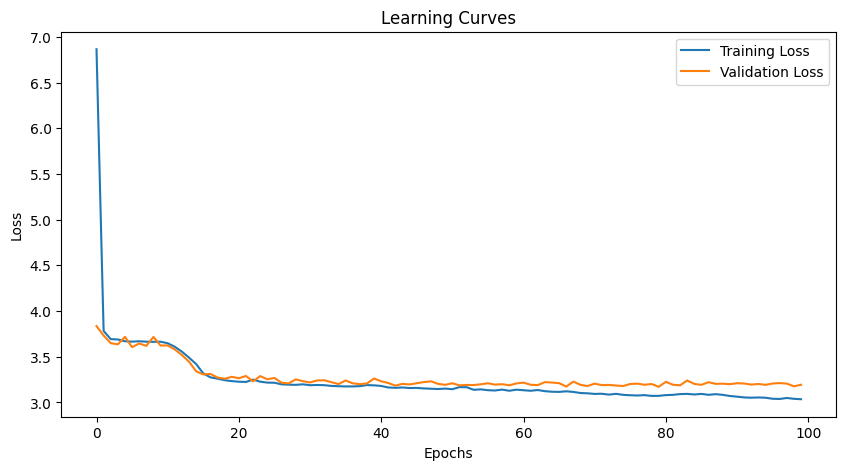

In [11]:
import matplotlib.pyplot as plt

# Plotting the learning curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curves')
plt.show()

In [12]:
# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Make sure the model is on the correct device
trained_model = trained_model.to(device)

# Check model output with correct device allocation
def check_model_output(model, dataset):
    model.eval()
    with torch.no_grad():
        for batch_images, _ in dataset:
            batch_images = batch_images.to(device)  # Move input to the same device as the model
            predictions = model(batch_images)
            print("Model output shape:", predictions.shape)
            print("Sample output (first 5 timesteps, first 5 characters):")
            print(predictions[0, :5, :5].cpu().numpy())  # Move to CPU for printing
            break  # We only need to check the first batch

# Call the function to check the output
check_model_output(trained_model, val_loader)

Model output shape: torch.Size([32, 2574, 74])
Sample output (first 5 timesteps, first 5 characters):
[[ -4.3838115  -5.263956   -8.77166    -9.754755   -7.929957 ]
 [ -3.6027164  -3.277244   -9.59787   -11.054581   -9.369425 ]
 [ -1.6192927  -1.8858111  -8.26881    -9.844233   -8.529186 ]
 [ -1.7207962  -2.051476   -8.41846   -10.233916   -8.007056 ]
 [ -1.7892746  -1.9674069  -8.231061  -10.185755   -7.5215526]]


/tmp/ipykernel_23/1234086752.py:15: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [13]:
# Calculate Character Error Rate (CER)
def calculate_cer(y_true, y_pred):
    total_cer = 0
    for true, pred in zip(y_true, y_pred):
        total_cer += editdistance.eval(true, pred) / max(len(true), 1)  # Avoid division by zero
    return total_cer / len(y_true)

In [14]:
# Calculate Word Error Rate (WER)
def calculate_wer(y_true, y_pred):
    total_wer = 0
    for true, pred in zip(y_true, y_pred):
        true_words = true.split()
        pred_words = pred.split()
        total_wer += editdistance.eval(true_words, pred_words) / max(len(true_words), 1)  # Avoid division by zero
    return total_wer / len(y_true)

In [15]:
!pip install editdistance
import editdistance
import torch.nn.functional as F

def greedy_decode(predictions):
    # Convert log probabilities to most likely indices (argmax)
    argmax_preds = torch.argmax(predictions, dim=2)
    
    output_texts = []
    for pred in argmax_preds:
        # Collapse repeated characters and remove blanks (assumed to be index 0)
        collapsed_preds = torch.unique_consecutive(pred[pred != 0]).cpu().numpy()
        result_text = "".join(num_to_char[idx] for idx in collapsed_preds)  # Convert indices to characters
        result_text = result_text.replace("<PAD>", "").strip()  # If you have padding tokens
        output_texts.append(result_text)
    
    return output_texts

# Modify the decode_batch_predictions function to use greedy_decode
def decode_batch_predictions(pred):
    pred = F.log_softmax(pred, dim=2)  # Apply log_softmax to the predictions
    return greedy_decode(pred)

def decode_label(label):
    # Use dictionary lookup to decode each index to its corresponding character
    return "".join(num_to_char[idx.item()] for idx in label if idx != -1)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.8/401.8 kB 7.4 MB/s eta 0:00:00


In [16]:
# Evaluate model
def evaluate_model(model, dataset):
    all_predictions = []
    all_ground_truth = []

    model.eval()
    with torch.no_grad():
        for batch_images, batch_labels in dataset:
            batch_images = batch_images.to(device) 
            batch_predictions = model(batch_images)
            decoded_predictions = decode_batch_predictions(batch_predictions)
            decoded_labels = [decode_label(label) for label in batch_labels]

            all_predictions.extend(decoded_predictions)
            all_ground_truth.extend(decoded_labels)

    cer = calculate_cer(all_ground_truth, all_predictions)
    wer = calculate_wer(all_ground_truth, all_predictions)

    print(f"Character Error Rate: {cer:.4f}")
    print(f"Word Error Rate: {wer:.4f}")

    return all_ground_truth, all_predictions

# Evaluate the model
ground_truth, predictions = evaluate_model(trained_model, val_loader)

/tmp/ipykernel_23/1234086752.py:15: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Character Error Rate: 0.9841
Word Error Rate: 0.9914


In [17]:
print("Sample ground truth and predictions:")
for gt, pred in zip(ground_truth[:5], predictions[:5]):
    print(f"Ground truth: '{gt}'")
    print(f"Prediction:   '{pred}'")
    print()

print("Lengths of first 5 samples:")
for gt, pred in zip(ground_truth[:5], predictions[:5]):
    print(f"Ground truth length: {len(gt)}, Prediction length: {len(pred)}")

Sample ground truth and predictions:
Ground truth: 'asks oneself correct questions,<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>'
Prediction:   'to'

Ground truth: 'and full of opportunities to progress.<PAD><PAD><PAD><PAD><PAD>'
Prediction:   'to'

Ground truth: 'like any other<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>'
Prediction:   'ae'

Ground truth: 'that they just have some<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>'
Prediction:   'ao'

Ground truth: 'have to do to advance is exhaustive<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>'
Prediction:   'ao'

Lengths of first 5 samples:
Ground truth length: 91, Prediction length: 2
Ground truth length: 63, Prediction length: 2
Ground truth length: 159, Prediction length: 2
Ground truth length: 119, Prediction length: 2
Ground truth length: 75, Prediction length: 2


In [18]:
# Analyze error patterns
from collections import Counter

def analyze_error_patterns(ground_truth, predictions):
    errors = []
    for true, pred in zip(ground_truth, predictions):
        true = true.replace("<PAD>", "").strip()
        pred = pred.replace("<PAD>", "").strip()
        if true != pred and true and pred:  # Ensure neither is empty after removing [UNK]
            errors.append((true, pred))
    
    print("Top 10 most common errors:")
    for (true, pred), count in Counter(errors).most_common(10):
        print(f"True: '{true}' -> Predicted: '{pred}' (Count: {count})")

# Re-run the analysis
analyze_error_patterns(ground_truth, predictions)

Top 10 most common errors:
True: 'asks oneself correct questions,' -> Predicted: 'to' (Count: 1)
True: 'and full of opportunities to progress.' -> Predicted: 'to' (Count: 1)
True: 'like any other' -> Predicted: 'ae' (Count: 1)
True: 'that they just have some' -> Predicted: 'ao' (Count: 1)
True: 'have to do to advance is exhaustive' -> Predicted: 'ao' (Count: 1)
True: 'me to a broken hope and lack' -> Predicted: 'ao' (Count: 1)
True: 'the part of' -> Predicted: 'ae' (Count: 1)
True: '23/07/23' -> Predicted: '0e' (Count: 1)
True: 'that this is possible.' -> Predicted: 'ae' (Count: 1)
True: 'continue to progress. The name' -> Predicted: 'to' (Count: 1)
